In [1]:
import s3fs
import xarray

In [2]:
from dask.distributed import Client

client = Client()
client

<Client: 'tcp://127.0.0.1:32931' processes=8 threads=32, memory=57.59 GiB>

# Cloud (Object Storage) dataset

In [3]:
fs = s3fs.S3FileSystem(
  client_kwargs=dict(endpoint_url='https://cephrgw01.ifca.es:8080'),
  anon=True)

store = s3fs.S3Map(root='CORDEX_EUR-44i_r1i1p1_UCAN-DeepESD-EE_v1_day_v20210617', s3=fs, check=False)
ds = xarray.open_zarr(store).chunk({"time": 1000})

In [4]:
ds

<xarray.Dataset>
Dimensions:        (driving_model: 8, experiment: 1, lat: 103, bnds: 2, lon: 221, time: 45990)
Coordinates:
  * driving_model  (driving_model) object 'CCCma-CanESM2' ... 'NOAA-GFDL-GFDL...
  * experiment     (experiment) object 'rcp85'
    height         float64 ...
  * lat            (lat) float64 21.75 22.25 22.75 23.25 ... 71.75 72.25 72.75
  * lon            (lon) float64 -44.75 -44.25 -43.75 ... 64.25 64.75 65.25
  * time           (time) object 1975-01-01 12:00:00 ... 2100-12-31 12:00:00
Dimensions without coordinates: bnds
Data variables:
    lat_bnds       (lat, bnds) float64 dask.array<chunksize=(103, 2), meta=np.ndarray>
    lon_bnds       (lon, bnds) float64 dask.array<chunksize=(221, 2), meta=np.ndarray>
    pr             (experiment, driving_model, time, lat, lon) float32 dask.array<chunksize=(1, 1, 1000, 103, 221), meta=np.ndarray>
    tas            (experiment, driving_model, time, lat, lon) float32 dask.array<chunksize=(1, 1, 1000, 103, 221), meta=np.ndarray>
    time_bnds      (time, bnds) object dask.array<chunksize=(1000, 1), meta=np.ndarray>
Attributes: (12/21)
    CORDEX_domain:                  EUR-44i
    Conventions:                    CF-1.4
    UCAN_comment:                   DeepESD-EE is the statistical downscaling...
    contact:                        meteo@unican.es
    creation_date:                  2021-06-17T14:17:20Z
    driving_experiment:             CCCma-CanESM2, historical, r1i1p1
    ...                             ...
    model_id:                       UCAN-DeepESD-EE
    product:                        output
    project_id:                     CORDEX
    rcm_version_id:                 v1
    references:                     https://doi.org/10.5194/gmd-13-2109-2020 ...
    tracking_id:                    hdl:21.14103/77c08c1c-088f-459b-9572-0557...

# Computation

In [5]:
arr_delayed = ds["tas"].isel(experiment=0, driving_model=0).mean("time")

In [6]:
arr_delayed

<xarray.DataArray 'tas' (lat: 103, lon: 221)>
dask.array<mean_agg-aggregate, shape=(103, 221), dtype=float32, chunksize=(103, 221), chunktype=numpy.ndarray>
Coordinates:
    driving_model  <U13 'CCCma-CanESM2'
    experiment     <U5 'rcp85'
    height         float64 ...
  * lat            (lat) float64 21.75 22.25 22.75 23.25 ... 71.75 72.25 72.75
  * lon            (lon) float64 -44.75 -44.25 -43.75 ... 64.25 64.75 65.25

In [7]:
%time arr = arr_delayed.compute()

CPU times: user 6.72 s, sys: 411 ms, total: 7.14 s
Wall time: 1min 44s


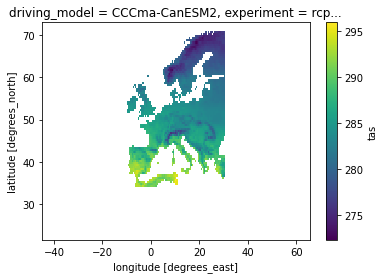

In [8]:
arr.plot()

# Multimodel comparison

In [9]:
ds

<xarray.Dataset>
Dimensions:        (driving_model: 8, experiment: 1, lat: 103, bnds: 2, lon: 221, time: 45990)
Coordinates:
  * driving_model  (driving_model) object 'CCCma-CanESM2' ... 'NOAA-GFDL-GFDL...
  * experiment     (experiment) object 'rcp85'
    height         float64 ...
  * lat            (lat) float64 21.75 22.25 22.75 23.25 ... 71.75 72.25 72.75
  * lon            (lon) float64 -44.75 -44.25 -43.75 ... 64.25 64.75 65.25
  * time           (time) object 1975-01-01 12:00:00 ... 2100-12-31 12:00:00
Dimensions without coordinates: bnds
Data variables:
    lat_bnds       (lat, bnds) float64 dask.array<chunksize=(103, 2), meta=np.ndarray>
    lon_bnds       (lon, bnds) float64 dask.array<chunksize=(221, 2), meta=np.ndarray>
    pr             (experiment, driving_model, time, lat, lon) float32 dask.array<chunksize=(1, 1, 1000, 103, 221), meta=np.ndarray>
    tas            (experiment, driving_model, time, lat, lon) float32 dask.array<chunksize=(1, 1, 1000, 103, 221), meta=np.ndarray>
    time_bnds      (time, bnds) object dask.array<chunksize=(1000, 1), meta=np.ndarray>
Attributes: (12/21)
    CORDEX_domain:                  EUR-44i
    Conventions:                    CF-1.4
    UCAN_comment:                   DeepESD-EE is the statistical downscaling...
    contact:                        meteo@unican.es
    creation_date:                  2021-06-17T14:17:20Z
    driving_experiment:             CCCma-CanESM2, historical, r1i1p1
    ...                             ...
    model_id:                       UCAN-DeepESD-EE
    product:                        output
    project_id:                     CORDEX
    rcm_version_id:                 v1
    references:                     https://doi.org/10.5194/gmd-13-2109-2020 ...
    tracking_id:                    hdl:21.14103/77c08c1c-088f-459b-9572-0557...

In [10]:
%time ensemble_mean = ds["tas"].isel(time=slice(0,100)).mean("time").compute()

CPU times: user 1.16 s, sys: 32.7 ms, total: 1.19 s
Wall time: 20.1 s


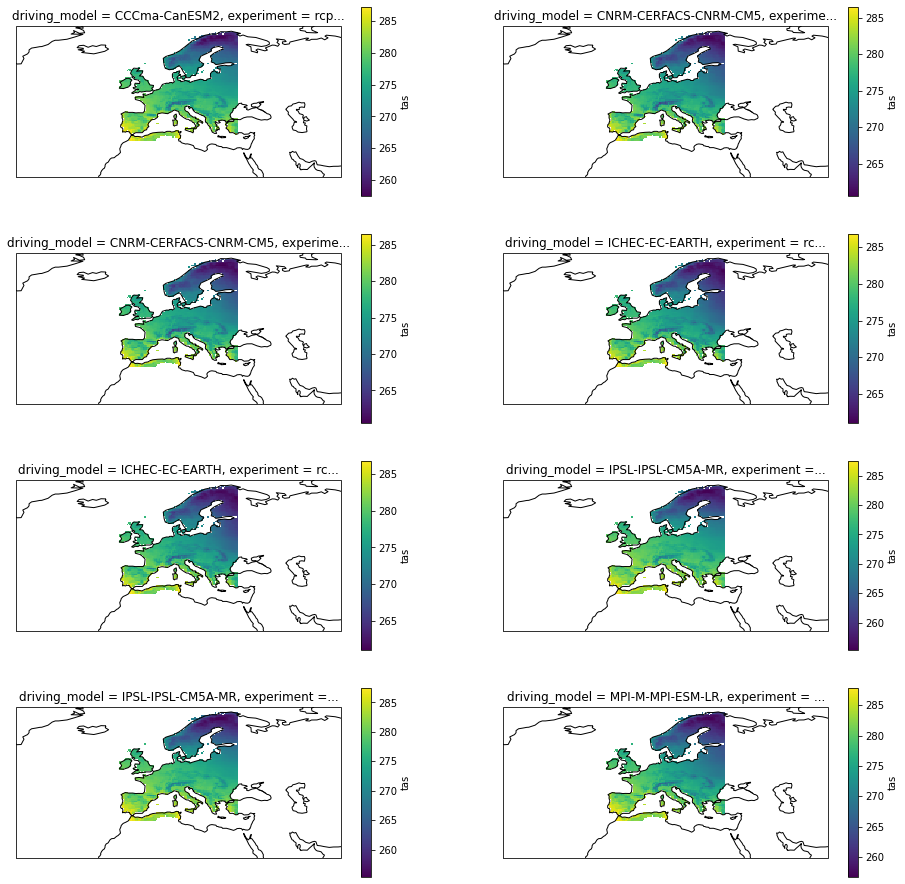

In [11]:
import matplotlib.pyplot as plt
import cartopy

%matplotlib inline

rows = len(ensemble_mean["driving_model"]) // 2
cols = 2
           
fig, axes = plt.subplots(nrows=rows,
                         ncols=cols,
                         figsize=(16,16),
                         subplot_kw={'projection': cartopy.crs.PlateCarree()})

for i in range(rows):
    for j in range(2):
        dm = ensemble_mean["driving_model"][i+j].item()
        axes[i,j].coastlines(lw=1)
        ensemble_mean.sel(driving_model=dm).plot(ax=axes[i,j])